In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install cython pyyaml==5.1

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
!pip install clearml

In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=74E1MQT3ZZD05XEGU9KGLQCZWEH1I0
%env CLEARML_API_SECRET_KEY=BqXaAM3UWu2XHbEznD2adyrzQlMy1q5vsWgiM4JHVu0e03YUbuFhVoJd7RbbILZATRE

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=74E1MQT3ZZD05XEGU9KGLQCZWEH1I0
env: CLEARML_API_SECRET_KEY=BqXaAM3UWu2XHbEznD2adyrzQlMy1q5vsWgiM4JHVu0e03YUbuFhVoJd7RbbILZATRE


In [2]:
!clearml-init

from clearml import Task

task = Task.init(project_name="DeepFashion", task_name="DeepFashion_mask_rcnn_R_101_FPN_3x")

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
^C
Traceback (most recent call last):
  File "/opt/conda/bin/clearml-init", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/clearml/cli/config/__main__.py", line 82, in main
    api_input = input()
KeyboardInterrupt
ClearML Task: overwriting (reusing) task id=f5e27ff419c2432ba2d2930850a24f10
2024-11-17 12:34:33,645 - clearml.Repository Detection - WARNING - Jupyter Notebook auto-logging failed, could not access: /kaggle/working/__notebook_source__.ipynb
2024-11-17 12:34:33,651 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: ht

/opt/conda/lib/python3.10/site-packages/clearml/utilities/process/mp.py:629: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [3]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
import os

setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, build_detection_test_loader

In [4]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("deepfashion_train", {}, "/kaggle/input/df2-train-img/ann_train.json", "/kaggle/input/df2-train-img/train_image/image")
register_coco_instances("deepfashion_val", {}, "/kaggle/input/df2-img-val/ann_val.json", "/kaggle/input/df2-img-val/image/image")

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("deepfashion_train",)
cfg.DATASETS.TEST = () 

cfg.SOLVER.BASE_LR = 0.002  # Start with a slightly higher learning rate
cfg.SOLVER.WARMUP_ITERS = int(0.1 * cfg.SOLVER.MAX_ITER)  # 10% of training as warm-up
cfg.SOLVER.MAX_ITER = 6000  # Adjust based on dataset size
cfg.SOLVER.STEPS = (3000, 5000)
cfg.SOLVER.GAMMA = 0.1      # Less aggressive decay

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Improves sampling quality
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13 

cfg.SOLVER.WEIGHT_DECAY = 0.0001

cfg.SOLVER.CHECKPOINT_PERIOD = 500  # Save model every 1000 iterations

# cfg.TEST.EVAL_PERIOD = 500
cfg.OUTPUT_DIR = "/kaggle/working"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [6]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/17 12:35:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [7]:
trainer.train()

[11/17 12:38:58 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)



[11/17 12:39:31 d2.utils.events]:  eta: 2:35:07  iter: 19  total_loss: 3.574  loss_cls: 2.549  loss_box_reg: 0.2856  loss_mask: 0.6929  loss_rpn_cls: 0.02441  loss_rpn_loc: 0.01653    time: 1.5613  last_time: 1.6272  data_time: 0.0992  last_data_time: 0.0854   lr: 2.057e-06  max_mem: 12270M
[11/17 12:40:03 d2.utils.events]:  eta: 2:35:51  iter: 39  total_loss: 3.554  loss_cls: 2.486  loss_box_reg: 0.3061  loss_mask: 0.6929  loss_rpn_cls: 0.02738  loss_rpn_loc: 0.01683    time: 1.5822  last_time: 1.6355  data_time: 0.0536  last_data_time: 0.0569   lr: 2.117e-06  max_mem: 12856M
[11/17 12:40:36 d2.utils.events]:  eta: 2:36:22  iter: 59  total_loss: 3.463  loss_cls: 2.42  loss_box_reg: 0.2964  loss_mask: 0.6928  loss_rpn_cls: 0.02235  loss_rpn_loc: 0.0154    time: 1.5898  last_time: 1.8582  data_time: 0.0607  last_data_time: 0.0568   lr: 2.177e-06  max_mem: 12856M
[11/17 12:41:07 d2.utils.events]:  eta: 2:36:02  iter: 79  total_loss: 3.401  loss_cls: 2.334  loss_box_reg: 0.3091  loss_mask

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("deepfashion_val",)

evaluator = COCOEvaluator("deepfashion_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "deepfashion_val")

WARNING [11/17 15:29:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/17 15:30:17 d2.data.datasets.coco]: Loading /kaggle/input/df2-img-val/ann_val.json takes 16.66 seconds.
[11/17 15:30:19 d2.data.datasets.coco]: Loaded 32153 images in COCO format from /kaggle/input/df2-img-val/ann_val.json
[11/17 15:30:32 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| short sleev.. | 12556        | long sleeve.. | 5966         | short sleev.. | 142          |
| long sleeve.. | 2011         |     vest      | 2113         |     sling     | 322          |
|    shorts     | 4167         |   trousers    | 9586         |     skirt     | 6522         |
| short sleev.. | 3127         | long sleeve.

In [9]:
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
print("Validation Metrics:", metrics)

[11/17 15:30:50 d2.evaluation.evaluator]: Start inference on 32153 batches


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[11/17 15:30:52 d2.evaluation.evaluator]: Inference done 11/32153. Dataloading: 0.0013 s/iter. Inference: 0.0933 s/iter. Eval: 0.0210 s/iter. Total: 0.1156 s/iter. ETA=1:01:54
[11/17 15:30:57 d2.evaluation.evaluator]: Inference done 53/32153. Dataloading: 0.0020 s/iter. Inference: 0.0932 s/iter. Eval: 0.0258 s/iter. Total: 0.1212 s/iter. ETA=1:04:50
[11/17 15:31:02 d2.evaluation.evaluator]: Inference done 97/32153. Dataloading: 0.0019 s/iter. Inference: 0.0919 s/iter. Eval: 0.0238 s/iter. Total: 0.1177 s/iter. ETA=1:02:52
[11/17 15:31:07 d2.evaluation.evaluator]: Inference done 144/32153. Dataloading: 0.0019 s/iter. Inference: 0.0911 s/iter. Eval: 0.0211 s/iter. Total: 0.1143 s/iter. ETA=1:00:58
[11/17 15:31:12 d2.evaluation.evaluator]: Inference done 191/32153. Dataloading: 0.0019 s/iter. Inference: 0.0906 s/iter. Eval: 0.0201 s/iter. Total: 0.1128 s/iter. ETA=1:00:04
[11/17 15:31:18 d2.evaluation.evaluator]: Inference done 235/32153. Dataloading: 0.0019 s/iter. Inference: 0.0909 s/it

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[11/17 16:44:42 d2.evaluation.evaluator]: Total inference time: 1:13:50.385537 (0.137812 s / iter per device, on 1 devices)
[11/17 16:44:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:49:36 (0.092597 s / iter per device, on 1 devices)
[11/17 16:45:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/17 16:45:16 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[11/17 16:45:35 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=2.46s)
creating index...
index created!
[11/17 16:45:39 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[11/17 16:46:12 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 33.45 seconds.
[11/17 16:46:13 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[11/17 16:46:24 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 10.88 seconds.
 Average Precis

KeyboardInterrupt: 

In [15]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0005999.pth")

predictor = DefaultPredictor(cfg)

[11/17 16:52:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/model_0005999.pth ...


/opt/conda/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:277: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



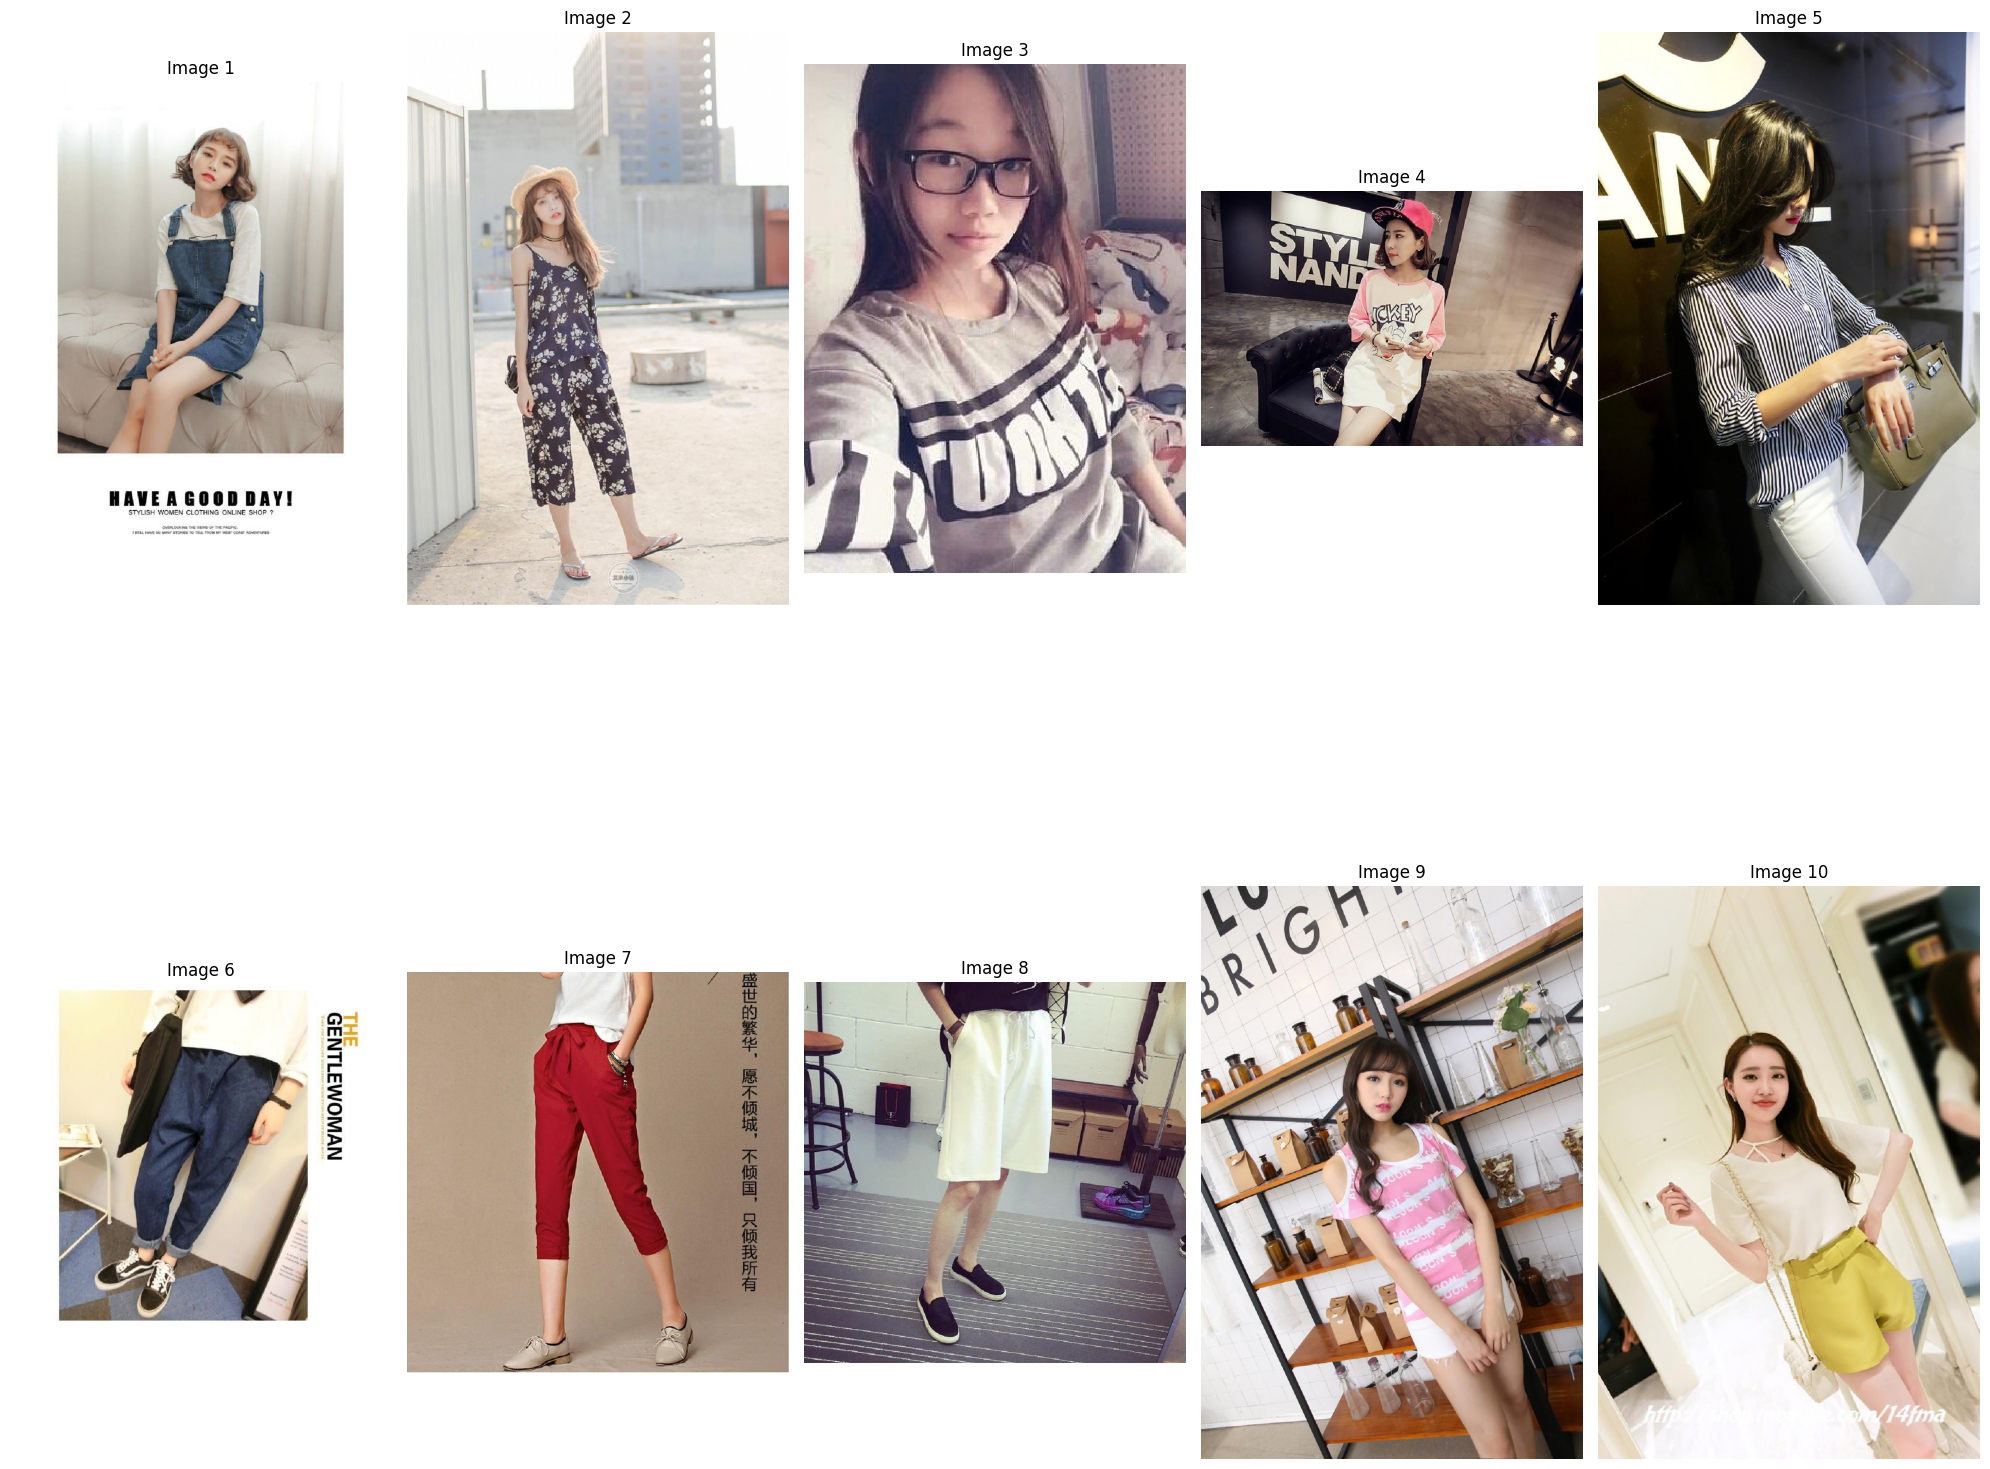

In [16]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

image_dir = "/kaggle/input/df2-train-img/train_image/image"

image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

plt.figure(figsize=(20, 20))
for i in range(10):
    # Select a random image
    img_path = random.choice(image_files)
    
    im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    outputs = predictor(im)
    
    v = Visualizer(im, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.subplot(2, 5, i + 1) 
    plt.imshow(v.get_image())
    plt.axis("off")
    plt.title(f"Image {i + 1}")

plt.tight_layout()
plt.show()


In [17]:
from IPython.display import FileLink

FileLink("model_final.pth")

/kaggle/working/model_final.pth